# tfp-multiple-changepoint-detection

Author: Henry Cooksley

Adapted from [Multiple changepoint detection and Bayesian model selection](https://www.tensorflow.org/probability/examples/Multiple_changepoint_detection_and_Bayesian_model_selection)

In [1]:
import numpy as np
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

from matplotlib import pylab as plt
%matplotlib inline
import scipy.stats

In [2]:
true_rates = [40, 3, 20, 50]
true_durations = [10, 20, 5, 35]
observed_counts = np.concatenate([
    scipy.stats.poisson(rate).rvs(num_steps) 
        for (rate, num_steps) in zip(true_rates, true_durations)
]).astype(np.float32)
observed_counts

array([36., 47., 45., 42., 42., 32., 31., 50., 37., 37.,  4.,  2.,  5.,
        4.,  5.,  1.,  4.,  2.,  2.,  1.,  3.,  7.,  5., 10.,  4.,  1.,
        1.,  4.,  3.,  0., 21., 19., 23., 18., 16., 42., 42., 61., 48.,
       67., 57., 39., 58., 55., 47., 45., 56., 43., 51., 46., 51., 52.,
       55., 50., 63., 37., 59., 47., 48., 50., 68., 45., 48., 57., 36.,
       45., 48., 52., 42., 50.], dtype=float32)

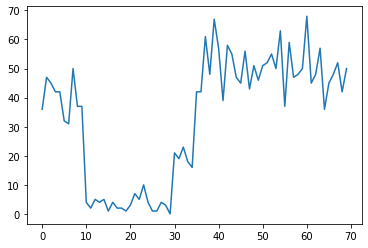

In [3]:
plt.plot(observed_counts);

In [4]:
num_states = 4
initial_state_logits = np.zeros([num_states], dtype=np.float32)
initial_state_logits

array([0., 0., 0., 0.], dtype=float32)

In [5]:
daily_change_prob = 0.05
transition_probs = daily_change_prob / (num_states-1) * np.ones(
    [num_states, num_states], dtype=np.float32)
transition_probs

array([[0.01666667, 0.01666667, 0.01666667, 0.01666667],
       [0.01666667, 0.01666667, 0.01666667, 0.01666667],
       [0.01666667, 0.01666667, 0.01666667, 0.01666667],
       [0.01666667, 0.01666667, 0.01666667, 0.01666667]], dtype=float32)

In [6]:
np.fill_diagonal(transition_probs, 
                 1-daily_change_prob)

In [7]:
print(f"Initial state logits:\n{initial_state_logits}")
print(f"Transition matrix:\n{transition_probs}")

Initial state logits:
[0. 0. 0. 0.]
Transition matrix:
[[0.95       0.01666667 0.01666667 0.01666667]
 [0.01666667 0.95       0.01666667 0.01666667]
 [0.01666667 0.01666667 0.95       0.01666667]
 [0.01666667 0.01666667 0.01666667 0.95      ]]


In [8]:
trainable_log_rates = tf.Variable(
    np.log(np.mean(observed_counts)) + tf.random.normal([num_states]),
    name='log_rates')
trainable_log_rates

<tf.Variable 'log_rates:0' shape=(4,) dtype=float32, numpy=array([1.9964865, 4.538932 , 3.279075 , 4.207787 ], dtype=float32)>

In [9]:
hmm = tfd.HiddenMarkovModel(
    initial_distribution=tfd.Categorical(
        logits=initial_state_logits),
    transition_distribution=tfd.Categorical(probs=transition_probs),
    observation_distribution=tfd.Poisson(log_rate=trainable_log_rates),
    num_steps=len(observed_counts))
hmm

<tfp.distributions.HiddenMarkovModel 'HiddenMarkovModel' batch_shape=[] event_shape=[70] dtype=float32>

In [10]:
rate_prior = tfd.LogNormal(5, 5)
rate_prior

<tfp.distributions.LogNormal 'LogNormal' batch_shape=[] event_shape=[] dtype=float32>

In [11]:
def log_prob():
    return (tf.reduce_sum(rate_prior.log_prob(tf.math.exp(trainable_log_rates))) +
           hmm.log_prob(observed_counts))

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
optimizer

In [13]:
@tf.function(autograph=False)
def train_op():
    with tf.GradientTape() as tape:
        neg_log_prob = -log_prob()
    grads = tape.gradient(neg_log_prob, [trainable_log_rates])[0]
    optimizer.apply_gradients([(grads, trainable_log_rates)])
    return neg_log_prob, tf.math.exp(trainable_log_rates)


In [14]:
for step in range(201):
    loss, rates = [t.numpy() for t in train_op()]
    if step % 20 == 0:
        print(f"step {step}: log prob {-loss} rates {rates}")

print("\n")
print(f"Inferred rates: {rates}")
print("\n")
print(f"True rates: {true_rates}")

step 0: log prob -390.3763427734375 rates [ 6.662445 84.68445  29.34361  60.812   ]
step 20: log prob -253.78102111816406 rates [ 2.6517007 49.742165  17.35282   36.997375 ]
step 40: log prob -250.164794921875 rates [ 3.633336 49.90231  18.930489 40.63772 ]
step 60: log prob -249.62203979492188 rates [ 3.286922 50.34471  19.212753 40.0322  ]
step 80: log prob -249.59718322753906 rates [ 3.353165 50.368507 19.320923 39.74094 ]
step 100: log prob -249.59228515625 rates [ 3.369562 50.27207  19.122206 39.89862 ]
step 120: log prob -249.5907745361328 rates [ 3.354747 50.303127 19.253853 39.921734]
step 140: log prob -249.5904541015625 rates [ 3.3555958 50.303604  19.209524  39.90825  ]
step 160: log prob -249.59054565429688 rates [ 3.3572466 50.300247  19.210756  39.902664 ]
step 180: log prob -249.59063720703125 rates [ 3.3572886 50.299755  19.215963  39.90197  ]
step 200: log prob -249.59075927734375 rates [ 3.3571205 50.299744  19.21477   39.90218  ]


Inferred rates: [ 3.3571205 50.2997

In [15]:
posterior_dists = hmm.posterior_marginals(observed_counts)
posterior_dists

<tfp.distributions.Categorical 'HiddenMarkovModel_posterior_marginals_Categorical' batch_shape=[70] event_shape=[] dtype=int32>

In [16]:
posterior_probs = posterior_dists.probs_parameter().numpy()
posterior_probs

array([[2.76725503e-25, 1.23395408e-02, 6.77984135e-05, 9.87592638e-01],
       [0.00000000e+00, 1.15387384e-02, 4.88987573e-10, 9.88461256e-01],
       [1.18994257e-36, 8.02060869e-03, 1.92191729e-09, 9.91979361e-01],
       [2.03378284e-33, 3.78164742e-03, 1.75185555e-08, 9.96218383e-01],
       [1.83895695e-33, 1.50516722e-03, 1.70623089e-08, 9.98494864e-01],
       [9.89665954e-23, 1.19445926e-04, 2.61265250e-05, 9.99854445e-01],
       [1.24653877e-21, 1.50169391e-04, 5.32520426e-05, 9.99796569e-01],
       [0.00000000e+00, 2.76367133e-03, 4.76062627e-11, 9.97236311e-01],
       [4.69369639e-28, 2.20885803e-03, 7.13559984e-07, 9.97790456e-01],
       [1.25436388e-24, 4.79245931e-03, 3.09181050e-05, 9.95176554e-01],
       [9.99997497e-01, 4.60106064e-18, 2.44716466e-06, 2.67142385e-12],
       [1.00000000e+00, 2.83523829e-22, 1.31969946e-09, 5.84860575e-18],
       [9.99999762e-01, 9.53506395e-19, 2.45334718e-07, 9.81931245e-15],
       [1.00000000e+00, 6.36416220e-20, 4.29265370e

In [17]:
def plot_state_posterior(ax, state_posterior_probs, title):
    ln1 = ax.plot(state_posterior_probs, c='blue', lw=3, label='p(state | counts)')
    ax.set_ylim(0., 1.1)
    ax.set_ylabel('posterior probability')
    ax2 = ax.twinx()
    ln2 = ax2.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
    ax2.set_title(title)
    ax2.set_xlabel('time')
    lns = ln1+ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=4)
    ax.grid(True, color='white')
    ax2.grid(False)


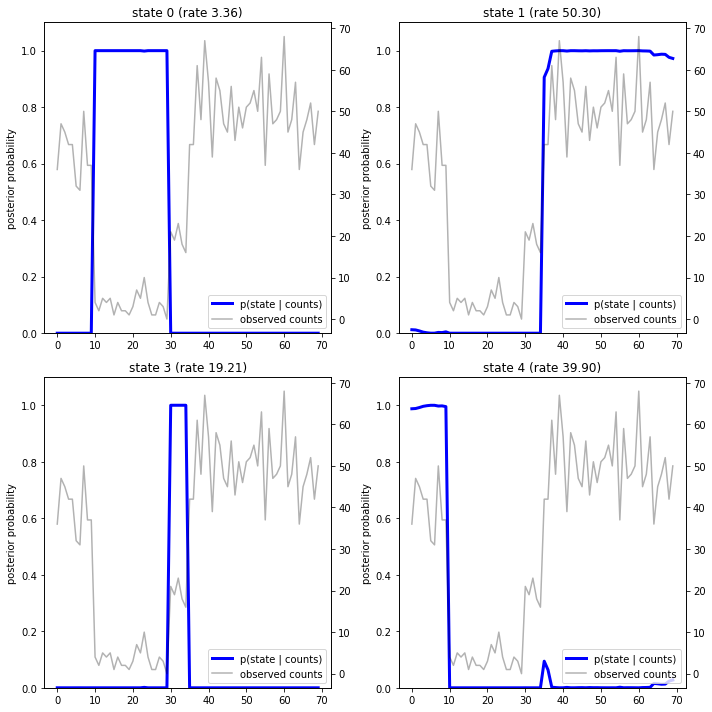

In [18]:
fig = plt.figure(figsize=(10, 10))
nrows_ncols = (2, 2)
plot_state_posterior(fig.add_subplot(*nrows_ncols, 1),
                    posterior_probs[:, 0],
                    title=f"state 0 (rate {rates[0]:.2f})")
plot_state_posterior(fig.add_subplot(*nrows_ncols, 2),
                    posterior_probs[:, 1],
                    title=f"state 1 (rate {rates[1]:.2f})")
plot_state_posterior(fig.add_subplot(*nrows_ncols, 3),
                    posterior_probs[:, 2],
                    title=f"state 3 (rate {rates[2]:.2f})")
plot_state_posterior(fig.add_subplot(*nrows_ncols, 4),
                    posterior_probs[:, 3],
                    title=f"state 4 (rate {rates[3]:.2f})")
plt.tight_layout()

In [19]:
most_probable_states = np.argmax(posterior_probs, axis=1)
most_probable_states

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [21]:
most_probable_rates = rates[most_probable_states]
most_probable_rates

array([39.90218  , 39.90218  , 39.90218  , 39.90218  , 39.90218  ,
       39.90218  , 39.90218  , 39.90218  , 39.90218  , 39.90218  ,
        3.3571205,  3.3571205,  3.3571205,  3.3571205,  3.3571205,
        3.3571205,  3.3571205,  3.3571205,  3.3571205,  3.3571205,
        3.3571205,  3.3571205,  3.3571205,  3.3571205,  3.3571205,
        3.3571205,  3.3571205,  3.3571205,  3.3571205,  3.3571205,
       19.21477  , 19.21477  , 19.21477  , 19.21477  , 19.21477  ,
       50.299744 , 50.299744 , 50.299744 , 50.299744 , 50.299744 ,
       50.299744 , 50.299744 , 50.299744 , 50.299744 , 50.299744 ,
       50.299744 , 50.299744 , 50.299744 , 50.299744 , 50.299744 ,
       50.299744 , 50.299744 , 50.299744 , 50.299744 , 50.299744 ,
       50.299744 , 50.299744 , 50.299744 , 50.299744 , 50.299744 ,
       50.299744 , 50.299744 , 50.299744 , 50.299744 , 50.299744 ,
       50.299744 , 50.299744 , 50.299744 , 50.299744 , 50.299744 ],
      dtype=float32)

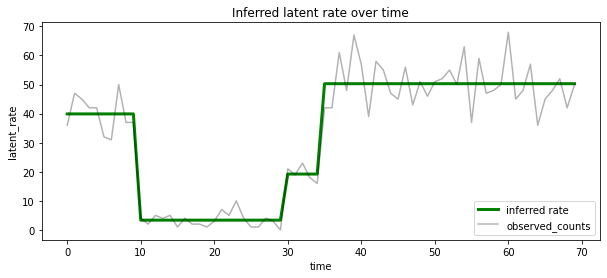

In [23]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(most_probable_rates, c='green', lw=3, label='inferred rate')
ax.plot(observed_counts, c='black', alpha=0.3, label='observed_counts')
ax.set_ylabel('latent_rate')
ax.set_xlabel('time')
ax.set_title('Inferred latent rate over time')
ax.legend(loc=4);